# 👀 Eye Disease Detection Using VGG16 & Deep Learning

🔍 Project Overview:

This project aims to build a deep learning model that can accurately classify eye images into five categories:

* Cataract

* Diabetic Retinopathy

* Glaucoma

* Normal

* Unknown (for unrelated random images)

We use transfer learning with the pre-trained VGG16 model, a powerful convolutional neural network originally trained on ImageNet. The model is fine-tuned and extended with custom layers to adapt it to the eye disease classification task.


📦 Key Features:
* ✅ Dataset Preparation: Retina disease images and random unrelated images are loaded from KaggleHub and organized into class folders.

* ✅ Data Augmentation: Applied to improve generalization using rotation, zoom, brightness, and flips.

* ✅ Transfer Learning: Used VGG16 as a base model to leverage powerful pre-learned features.

* ✅ Custom Classifier Head: Added fully connected layers on top of VGG16 for classification into 5 categories.

* ✅ Class Balancing: Automatically computed class weights to handle imbalanced data.

* ✅ Model Training: Fine-tuned with early stopping and learning rate adjustment callbacks.

* ✅ Evaluation: Includes classification report, confusion matrix, confidence histograms, and low-confidence analysis.

* ✅ Model Saving: Final model saved in .h5 format for reuse in Flask or any web app deployment.

* ✅ Download Option: Easily download the trained model from Google Colab to your local machine.

**🚀 Deployment-Ready:**

The trained model (eye_disease_model.h5) is ready to be integrated into a Flask web application for real-time predictions, allowing users to upload eye images and get instant results.

# 🧩 Importing Required Libraries



This block imports all the essential Python libraries needed for data handling, visualization, machine learning, and building a deep learning model using the VGG16 architecture.

In [ ]:
import os  # For interacting with the operating system (e.g., file paths)
import shutil  # For high-level file operations like copying or deleting directories

import numpy as np  # For numerical computations and handling arrays
import logging  # To log messages for debugging and monitoring

import matplotlib.pyplot as plt  # For plotting graphs and displaying images
import seaborn as sns  # For enhanced, beautiful statistical visualizations

import tensorflow as tf  # TensorFlow library for building deep learning models

from sklearn.metrics import classification_report, confusion_matrix
# To evaluate model performance by showing precision, recall, F1-score, and confusion matrix

from sklearn.utils.class_weight import compute_class_weight
# To compute weights for each class to handle imbalanced datasets

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# For generating batches of augmented image data (used during training)

from tensorflow.keras.applications import VGG16
# To import the pre-trained VGG16 model for transfer learning

from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
# Layers used to construct the final classification model

from tensorflow.keras.models import Model
# To create a complete model by combining layers

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# To stop training early if validation doesn't improve and to reduce learning rate on plateau

import kagglehub  # For downloading models or datasets hosted on KaggleHub


# 📁 Downloading and Preparing the Dataset



This section performs five key tasks:

1. Sets up logging to track progress.

2. Downloads the retina dataset from KaggleHub.

3. Copies the dataset to a writable location.

4. Downloads a random image collection to simulate unknown data.

5. Prepares an Unknown folder with up to 1000 random images (used later for testing the model's generalization ability).

In [ ]:
logging.basicConfig(level=logging.INFO)  # Set logging level to INFO so we can track progress with log messages

# ✅ Step 1: Download the retina disease dataset from KaggleHub
retina_path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")
input_data_path = os.path.join(retina_path, "dataset")  # Define the path to the 'dataset' directory inside the downloaded data

# ✅ Step 2: Copy the dataset to a writable directory in the current environment
DATASET_PATH = "/kaggle/working/dataset"
shutil.copytree(input_data_path, DATASET_PATH, dirs_exist_ok=True)  # Copy everything from input_data_path to DATASET_PATH. If folders exist, it's okay.

# ✅ Step 3: Download the random image dataset from Unsplash (used as unknown inputs)
unsplash_path = kagglehub.dataset_download("lprdosmil/unsplash-random-images-collection")
UNSPLASH_SOURCE = os.path.join(unsplash_path, "unsplash-images-collection")  # Get the path to the unsplash images

# ✅ Step 4: Create a folder named "Unknown" in the dataset directory
unknown_target = os.path.join(DATASET_PATH, "Unknown")
os.makedirs(unknown_target, exist_ok=True)  # Create the folder only if it doesn't already exist

# ✅ Step 5: Copy up to 1000 random images from Unsplash to the Unknown folder
count = 0
for fname in os.listdir(UNSPLASH_SOURCE):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):  # Make sure it's an image file
        shutil.copy(
            os.path.join(UNSPLASH_SOURCE, fname),               # Source file path
            os.path.join(unknown_target, f"unknown_{count}.jpg")  # New filename with count
        )
        count += 1
        if count >= 1000:  # Stop after copying 1000 images
            break

# Log how many images were copied in total
logging.info(f"✅ Copied {count} random images to {unknown_target}")


# ⚙️ Defining Configuration Constants


This block sets up the basic hyperparameters and category labels that will be used throughout the model training and evaluation process. These constants ensure consistency and make it easy to adjust settings like image size, batch size, and class labels.

In [ ]:
IMG_SIZE = (224, 224)  # All input images will be resized to 224x224 pixels to match the input size expected by VGG16

BATCH_SIZE = 32  # The number of images processed in one training step (affects speed and memory usage)

EPOCHS = 30  # The number of times the entire training dataset will be passed through the model

CATEGORIES = ["cataract", "diabetic_retinopathy", "glaucoma", "normal", "Unknown"]  # List of possible classes the model should recognize — "Unknown" is for random non-eye images


# 📊 Creating Image Data Generators (with Augmentation)


This block prepares the training and validation datasets using ImageDataGenerator, which loads images from folders and applies real-time data augmentation. Augmentation helps prevent overfitting by making the model see slightly modified versions of the same images.

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values from [0, 255] to [0, 1]
    validation_split=0.2,         # Split 20% of the data for validation
    rotation_range=25,            # Randomly rotate images up to 25 degrees
    zoom_range=0.25,              # Randomly zoom in up to 25%
    width_shift_range=0.15,       # Shift image width-wise up to 15%
    height_shift_range=0.15,      # Shift image height-wise up to 15%
    horizontal_flip=True,         # Randomly flip images horizontally
    brightness_range=[0.7, 1.3]   # Randomly adjust image brightness between 70% and 130%
)

train_data = datagen.flow_from_directory(
    DATASET_PATH,             # Root directory where all the image folders are located
    target_size=IMG_SIZE,     # Resize all images to 224x224 pixels
    batch_size=BATCH_SIZE,    # Process images in batches of 32
    class_mode='categorical', # Labels will be one-hot encoded (used for multi-class classification)
    subset='training',        # Use this portion as training data (80%)
    shuffle=True              # Shuffle images to ensure randomness
)


val_data = datagen.flow_from_directory(
    DATASET_PATH,             # Same dataset, but using the validation split
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',      # Use this portion as validation data (20%)
    shuffle=False             # Don't shuffle validation data (optional, for consistent results)
)



# Print/log which class names were detected and their corresponding index
logging.info(f"Detected classes: {train_data.class_indices}")


Found 4018 images belonging to 5 classes.
Found 1001 images belonging to 5 classes.


# 🧠 Building and Compiling the VGG16-Based Model



This block loads a pre-trained VGG16 model (used for feature extraction), adds a custom classification head for your specific task, unfreezes some layers for fine-tuning, and compiles the final model. This is a classic transfer learning approach where we reuse a powerful model trained on ImageNet and adapt it for a new problem.

In [ ]:
# Load base VGG16 model without the top (fully connected) layer
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# This loads a pre-trained VGG16 model with weights from ImageNet.
# We exclude the top layer because we’ll add our own custom classification layers.


# 🔓 Unfreeze only the last 10 layers to allow fine-tuning
for layer in base_model.layers[:-10]:
    layer.trainable = False  # Freeze earlier layers (do not update their weights)
for layer in base_model.layers[-10:]:
    layer.trainable = True   # Allow training on the last 10 layers
# This helps retain learned features while slightly adapting the model to your dataset.


# 🧠 Custom classification head (goes on top of VGG16)
x = GlobalAveragePooling2D()(base_model.output)  # Reduces each feature map to a single value
x = Dense(256, activation='relu')(x)             # Fully connected layer with 256 neurons
x = Dropout(0.5)(x)                               # Drop 50% of neurons randomly during training (to prevent overfitting)
x = Dense(128, activation='relu')(x)             # Another dense layer with 128 neurons
x = Dropout(0.3)(x)                               # Drop 30% this time


# 🔚 Output layer: 5 neurons = 5 classes, softmax to give class probabilities
output = Dense(5, activation='softmax')(x)


# ✅ Combine base and custom head into one model
model = Model(inputs=base_model.input, outputs=output)


# 🔧 Compile the model with a small learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Adam optimizer with a very low learning rate for fine-tuning
    loss='categorical_crossentropy',           # Used for multi-class classification
    metrics=['accuracy']                       # Track accuracy during training
)


# 🔍 Print out the model summary to see all layers and parameters
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,879,557 (56.76 MB)

 Trainable params: 13,734,149 (52.39 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

# 🚀 Computing Class Weights, Setting Callbacks, and Training the Model



This section improves training by:

1. Balancing the classes using computed weights (important if some categories have fewer samples).

2. Adding callbacks to stop training early or adjust learning rate when needed.

3. Finally, it starts the model training using model.fit().

In [ ]:
# ⚖️ Compute class weights to handle class imbalance
y_train = train_data.classes  # Get the actual class labels from the training data

class_weights = compute_class_weight(
    class_weight='balanced',             # Automatically compute weights to balance classes
    classes=np.unique(y_train),          # List of unique class labels
    y=y_train                            # Actual training labels
)

class_weights = dict(enumerate(class_weights))  # Convert weights into dictionary format: {class_index: weight}
print("Class Weights:", class_weights)          # Show the computed weights
print("Class Indices:", train_data.class_indices)  # Show how class names map to indices


# ⏱️ Define callbacks to improve training stability and performance
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',        # Monitor validation accuracy
        patience=4,                    # Stop training if it doesn't improve for 4 epochs
        restore_best_weights=True      # Restore the weights from the best epoch
    ),
    ReduceLROnPlateau(
        monitor='val_loss',            # Watch validation loss
        factor=0.5,                    # Reduce learning rate by half if plateau is detected
        patience=2,                    # Wait 2 epochs before reducing
        verbose=1                      # Print when learning rate is reduced
    )
]


# 🚀 Start model training
history = model.fit(
    train_data,                  # Training data generator
    validation_data=val_data,    # Validation data generator
    epochs=EPOCHS,               # Number of training epochs (e.g., 30)
    class_weight=class_weights, # Use computed class weights for balanced learning
    callbacks=callbacks          # Use callbacks to optimize training
)


Class Weights: {0: np.float64(1.2517133956386293), 1: np.float64(0.9670276774969916), 2: np.float64(0.9142207053469852), 3: np.float64(0.9970223325062034), 4: np.float64(0.9344186046511628)}
Class Indices: {'Unknown': 0, 'cataract': 1, 'diabetic_retinopathy': 2, 'glaucoma': 3, 'normal': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 151s 992ms/step - accuracy: 0.2769 - loss: 1.6380 - val_accuracy: 0.6663 - val_loss: 0.8846 - learning_rate: 1.0000e-05
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 110s 877ms/step - accuracy: 0.5968 - loss: 0.9401 - val_accuracy: 0.6773 - val_loss: 0.7626 - learning_rate: 1.0000e-05
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 146s 906ms/step - accuracy: 0.6708 - loss: 0.8075 - val_accuracy: 0.7303 - val_loss: 0.7148 - learning_rate: 1.0000e-05
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 117s 929ms/step - accuracy: 0.7132 - loss: 0.7081 - val_accuracy: 0.7383 - val_loss: 0.6404 - learning_rate: 1.0000e-05
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 107s 844ms/step - accuracy: 0.7427 - loss: 0.6481 - val_accuracy: 0.7702 - val_loss: 0.5859 - learning_rate: 1.0000e-05
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 102s 807ms/step - accuracy: 0.7827 - loss: 0.5640 - val_accuracy: 0.7802 - val_loss: 0.5738 - learning_rate: 1.0000e-05
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 

# 🔍 Making Predictions and Extracting Confidence Scores



This section uses the trained model to make predictions on the validation dataset. It also extracts the predicted class labels and the model’s confidence for each prediction.

In [ ]:
# 🔍 Predict on validation set
val_preds = model.predict(val_data)
# Get prediction probabilities for each class on the validation dataset

y_true = val_data.classes
# True class labels from the validation data

y_pred = np.argmax(val_preds, axis=1)
# Convert prediction probabilities to class labels by selecting the index with the highest probability

# 📌 Calculate confidence for each prediction
confidences = np.max(val_preds, axis=1)
# For each prediction, get the highest probability (i.e., model's confidence in its prediction)



32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 512ms/step


# 📊 Visualizing Model Confidence with a Boxplot





This block creates a boxplot to show the distribution of confidence scores for each true class label. This helps assess if the model is more or less confident depending on the disease category.

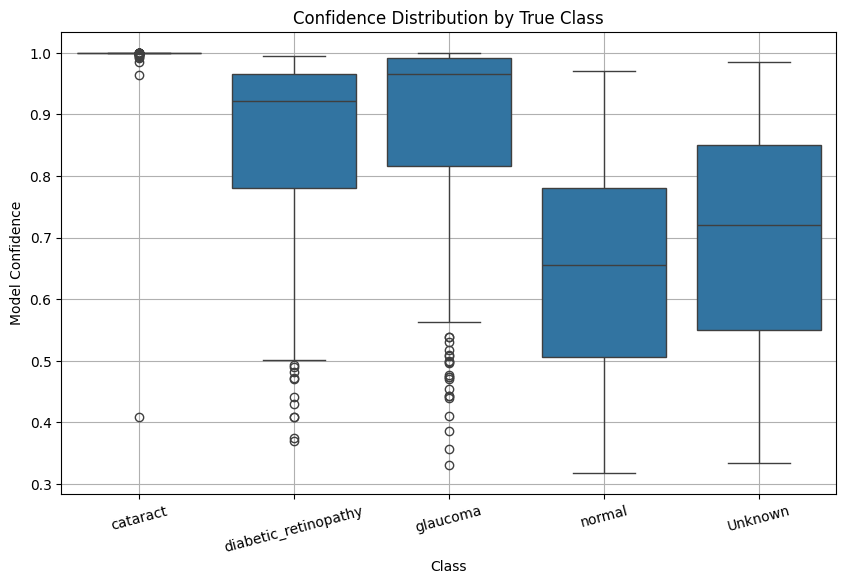

In [ ]:
import pandas as pd  # For creating and manipulating data in tabular format


# 📊 Create a DataFrame with true class names and their confidence scores
true_labels = [CATEGORIES[i] for i in y_true]
# Convert numeric labels (0, 1, 2...) back to actual class names (e.g., 'cataract')

df = pd.DataFrame({
    "Confidence": confidences,  # Confidence score from model (0.0 to 1.0)
    "Class": true_labels        # Actual class label name
})

# 📉 Plot a boxplot of confidence scores for each class
plt.figure(figsize=(10, 6))  # Set the figure size
sns.boxplot(x="Class", y="Confidence", data=df)  # Create a boxplot grouped by class

plt.title("Confidence Distribution by True Class")  # Add a title to the plot
plt.ylabel("Model Confidence")                      # Label the y-axis
plt.xticks(rotation=15)                             # Tilt x-axis labels for better readability
plt.grid(True)                                      # Show grid lines
plt.show()                                          # Display the plot

# 🚨 Displaying Low-Confidence Predictions



This block goes through the model’s predictions and prints out cases where the prediction confidence is below 75%. These are often misclassified or ambiguous examples, so reviewing them can help improve the model.

In [ ]:
# 🚨 Show predictions where the model is not confident (confidence < 75%)
print("\n⚠️ Low-confidence predictions (confidence < 0.75):")

for i in range(len(confidences)):  # Loop through each prediction
    if confidences[i] < 0.75:      # Check if confidence is below 75%
        print(
            f"Sample {i}: Predicted '{CATEGORIES[y_pred[i]]}', "
            f"True '{CATEGORIES[y_true[i]]}', Confidence: {confidences[i]:.2f}"
        )
        # Print the index, predicted label, true label, and confidence rounded to 2 decimals


⚠️ Low-confidence predictions (confidence < 0.75):
Sample 45: Predicted 'cataract', True 'cataract', Confidence: 0.41
Sample 163: Predicted 'diabetic_retinopathy', True 'diabetic_retinopathy', Confidence: 0.49
Sample 165: Predicted 'Unknown', True 'diabetic_retinopathy', Confidence: 0.65
Sample 166: Predicted 'Unknown', True 'diabetic_retinopathy', Confidence: 0.58
Sample 171: Predicted 'Unknown', True 'diabetic_retinopathy', Confidence: 0.60
Sample 173: Predicted 'diabetic_retinopathy', True 'diabetic_retinopathy', Confidence: 0.55
Sample 174: Predicted 'normal', True 'diabetic_retinopathy', Confidence: 0.54
Sample 176: Predicted 'diabetic_retinopathy', True 'diabetic_retinopathy', Confidence: 0.41
Sample 177: Predicted 'normal', True 'diabetic_retinopathy', Confidence: 0.62
Sample 180: Predicted 'Unknown', True 'diabetic_retinopathy', Confidence: 0.47
Sample 181: Predicted 'Unknown', True 'diabetic_retinopathy', Confidence: 0.61
Sample 182: Predicted 'normal', True 'diabetic_retinop

# 📊 Plotting a Histogram of Prediction Confidence



This section draws a histogram showing how confident the model is when making predictions on the validation set. It also marks a confidence threshold line at 0.75, helping you spot how many predictions fall below it (i.e., low-confidence predictions).

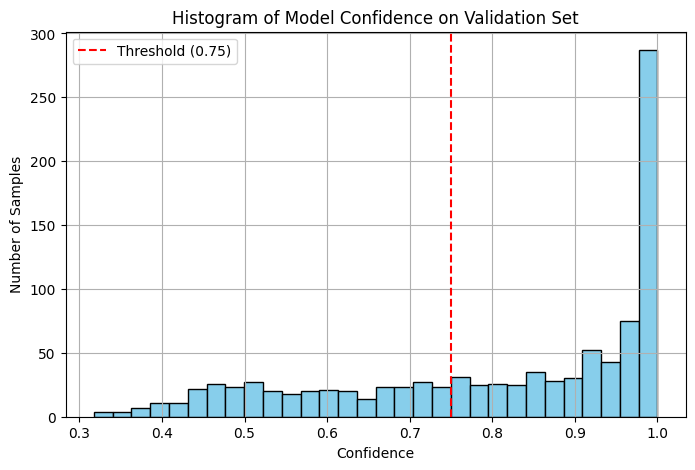

In [ ]:
# 📊 Plot a histogram of confidence scores
plt.figure(figsize=(8, 5))  # Set the figure size

plt.hist(confidences, bins=30, color="skyblue", edgecolor="black")
# Plot the histogram using 30 bins; sky-blue bars with black edges for visibility

plt.title("Histogram of Model Confidence on Validation Set")  # Title of the plot
plt.xlabel("Confidence")  # X-axis label
plt.ylabel("Number of Samples")  # Y-axis label
plt.axvline(0.75, color='red', linestyle='--', label="Threshold (0.75)")
# Add a vertical dashed red line at confidence = 0.75 to highlight the low-confidence cutoff

plt.legend()  # Show the legend explaining the red line
plt.grid(True)  # Add gridlines for better readability
plt.show()  # Display the plot


# 🧪 Evaluating the Model with a Classification Report



This section reuses predictions from the model on the validation set and prints out a classification report, which shows how well the model performed on each class. It's a standard, detailed way to evaluate multi-class classifiers.

In [ ]:
# 📊 Re-run predictions on the validation data
val_preds = model.predict(val_data)  # Get class probabilities for each validation sample

y_true = val_data.classes            # Actual labels from the validation set
y_pred = np.argmax(val_preds, axis=1)  # Convert predicted probabilities into class labels

# 📋 Print classification report with precision, recall, F1-score, and support for each class
print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(train_data.class_indices.keys())  # Map class indices back to class names
))


32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step

Classification Report:

                      precision    recall  f1-score   support

             Unknown       0.99      0.99      0.99       160
            cataract       0.87      0.86      0.87       207
diabetic_retinopathy       0.84      0.88      0.86       219
            glaucoma       0.71      0.59      0.64       201
              normal       0.68      0.75      0.71       214

            accuracy                           0.81      1001
           macro avg       0.82      0.82      0.81      1001
        weighted avg       0.81      0.81      0.81      1001



# 🔍 Visualizing Model Performance with a Confusion Matrix



This section computes and displays a normalized confusion matrix, which shows how many predictions were correct or incorrect for each class. Normalization helps by converting raw counts into percentages, making the matrix easier to interpret across imbalanced classes.

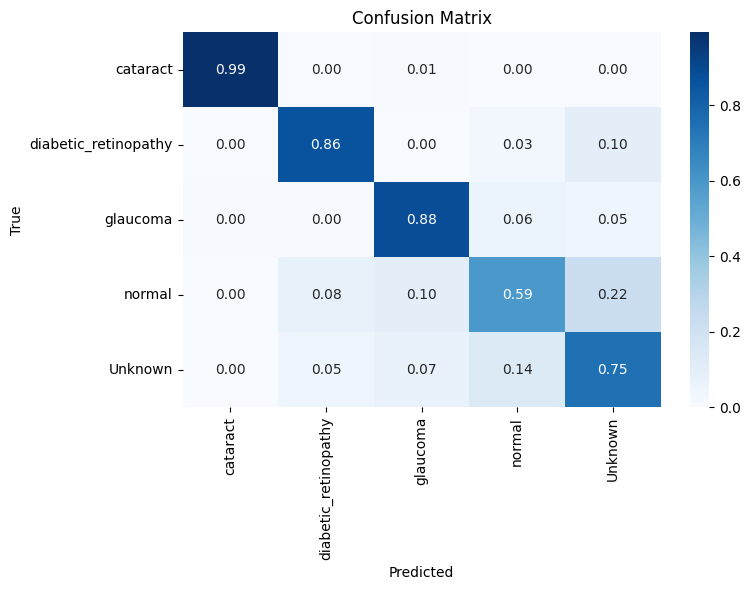

In [ ]:
cm = confusion_matrix(y_true, y_pred)  # Generate a confusion matrix: rows = true classes, columns = predicted classes

plt.figure(figsize=(8, 6))  # Set the figure size

# Normalize the confusion matrix by dividing each row by the sum of that row
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
sns.heatmap(
    cm_normalized,
    annot=True,               # Show values inside cells
    fmt='.2f',                # Format numbers to 2 decimal places
    cmap='Blues',             # Use blue color shades
    xticklabels=CATEGORIES,   # Class names for predicted values
    yticklabels=CATEGORIES    # Class names for true values
)
plt.xlabel("Predicted")       # X-axis label
plt.ylabel("True")            # Y-axis label
plt.title("Confusion Matrix") # Plot title
plt.tight_layout()            # Adjust layout to fit everything nicely
plt.show()                    # Display the plot


# 📈 Plotting Training vs. Validation Accuracy



This plot shows how the model’s accuracy evolved during each training epoch. By comparing training and validation accuracy, you can check for signs of overfitting (e.g., when validation accuracy flattens or drops while training accuracy keeps rising).

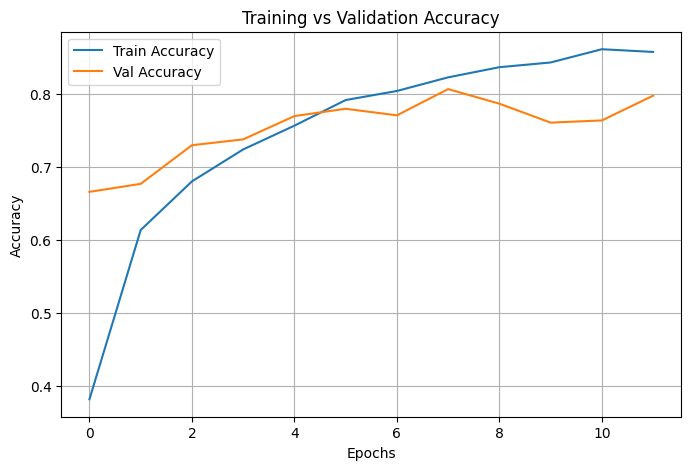

In [ ]:
plt.figure(figsize=(8, 5))  # Set the size of the plot

# Plot training and validation accuracy curves
plt.plot(history.history['accuracy'], label='Train Accuracy')       # Accuracy on training data
plt.plot(history.history['val_accuracy'], label='Val Accuracy')     # Accuracy on validation data

plt.title("Training vs Validation Accuracy")  # Title of the plot
plt.xlabel("Epochs")                          # X-axis: number of epochs
plt.ylabel("Accuracy")                        # Y-axis: accuracy score
plt.legend()                                  # Show the legend to distinguish lines
plt.grid(True)                                # Add grid lines for better readability
plt.show()                                    # Display the plot



# 💾 Saving the Trained Model



After training is complete, the model is saved to disk in .h5 format using model.save(). This is important for:

* ✅ Reusability: You can reload the model later for predictions without retraining.

* ✅ Fine-tuning: If needed, you can continue training from the saved model.

* ✅ Deployment: The .h5 file can be loaded in a Flask web app (or any other Python backend) to serve real-time predictions via an API or web interface.

This makes it ideal for integrating deep learning into production environments or user-facing applications.

In [ ]:
os.makedirs("models", exist_ok=True)
# Create a 'models' folder to store the trained model

model.save("models/eye_disease_model.h5")
# Save the complete model — including architecture, weights, and training config
# Can be loaded later with tf.keras.models.load_model()


# Downloading the Model from Colab



This line allows you to download the .h5 file (your trained model) directly from the Google Colab environment to your computer. This is useful for:

* Keeping a backup

* Using the model offline

* Uploading it to a server for deployment (e.g., in a Flask web app)

In [ ]:
from google.colab import files  # Colab-specific utility for file download

files.download("models/eye_disease_model.h5")  # Triggers download of the saved model file to your local device


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>